In [ ]:
# Human Activity Recognition Analysis
# Author: Alex Gurung

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


Matplotlib is building the font cache; this may take a moment.


All libraries imported successfully!
NumPy version: 2.3.5
Pandas version: 2.3.3


In [3]:

print("Loading data...")
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header=None, names=['activity'])
y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', header=None, names=['activity'])

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")

# Standardize the features
print("\nStandardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to arrays for easier handling
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print("Data loaded and standardized successfully!")
print(f"Feature mean after scaling: {X_train_scaled.mean():.6f}")
print(f"Feature std after scaling: {X_train_scaled.std():.6f}")

Loading data...
Training set shape: (7352, 561)
Test set shape: (2947, 561)
Number of features: 561
Number of training samples: 7352
Number of test samples: 2947

Standardizing features...
Data loaded and standardized successfully!
Feature mean after scaling: 0.000000
Feature std after scaling: 1.000000


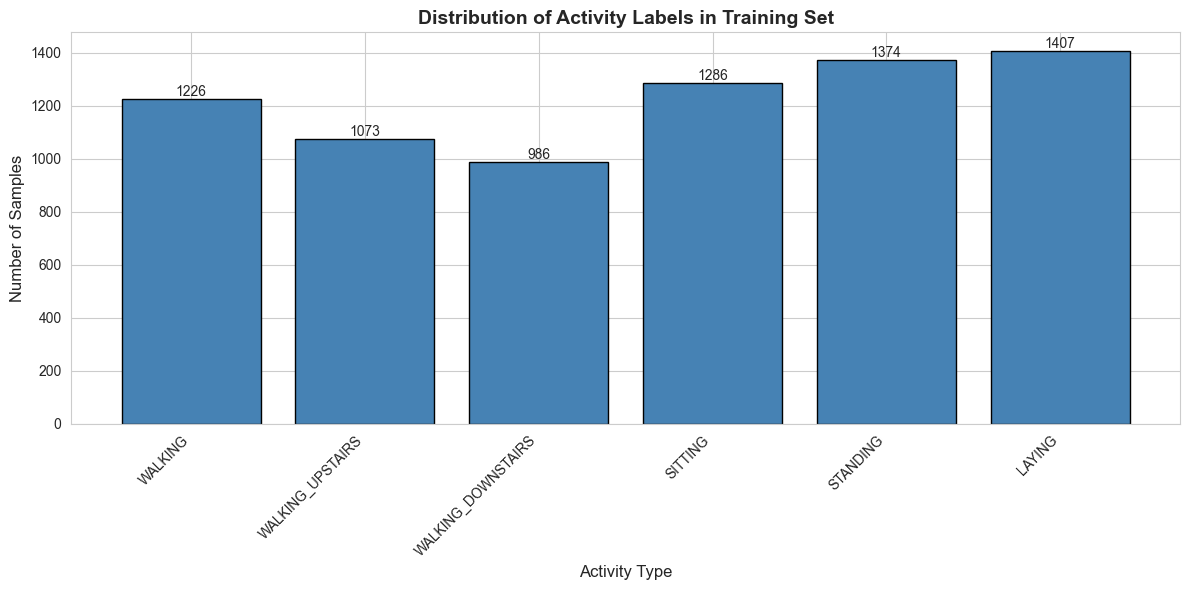


Activity Distribution:
WALKING: 1226 samples (16.7%)
WALKING_UPSTAIRS: 1073 samples (14.6%)
WALKING_DOWNSTAIRS: 986 samples (13.4%)
SITTING: 1286 samples (17.5%)
STANDING: 1374 samples (18.7%)
LAYING: 1407 samples (19.1%)


In [4]:
#Activity Distribution Visualization (Step 2 - Part 1)
# ============================================================================
# Create activity labels dictionary
activity_labels = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS', 
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

# Plot distribution
plt.figure(figsize=(12, 6))
counts = pd.Series(y_train).value_counts().sort_index()
bars = plt.bar(range(1, 7), counts.values, color='steelblue', edgecolor='black')
plt.xlabel('Activity Type', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Distribution of Activity Labels in Training Set', fontsize=14, fontweight='bold')
plt.xticks(range(1, 7), [activity_labels[i] for i in range(1, 7)], rotation=45, ha='right')

# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('activity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nActivity Distribution:")
for activity, count in counts.items():
    print(f"{activity_labels[activity]}: {count} samples ({count/len(y_train)*100:.1f}%)")


Performing PCA analysis...


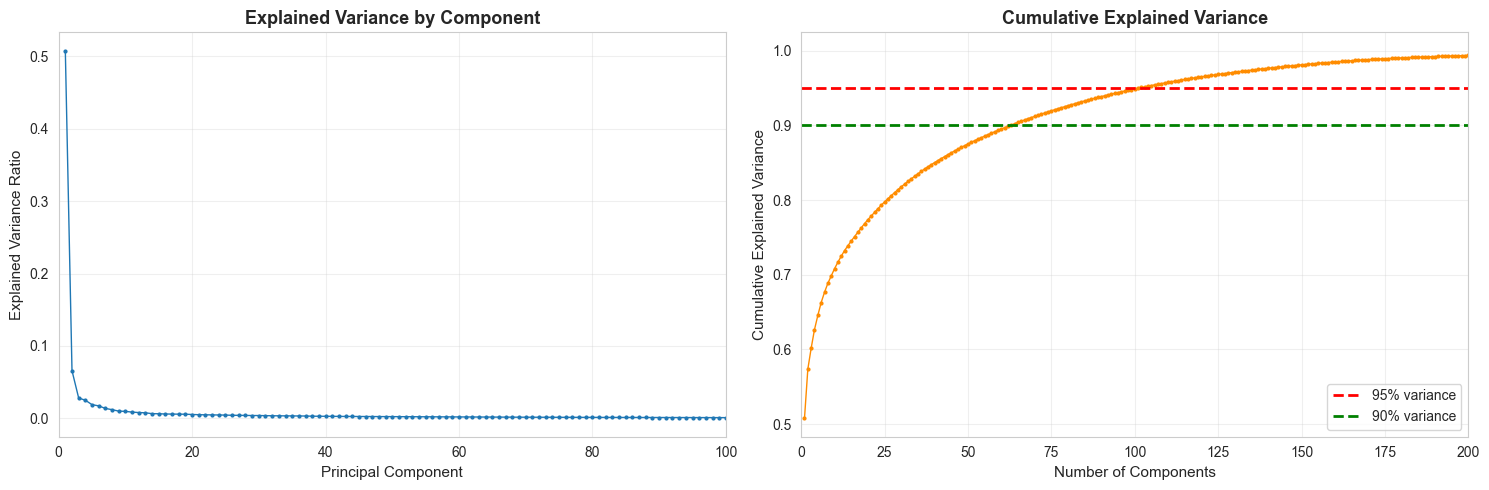


PCA Results:
Components for 90% variance: 63
Components for 95% variance: 102
Total components: 561

First component explains: 0.5078 (50.78%)
First 10 components explain: 0.7082 (70.82%)

*** Using k = 102 components for feature selection ***


In [5]:
#PCA Analysis - Explained Variance (Step 2 - Part 2)
# ============================================================================
# Perform PCA on all components
print("Performing PCA analysis...")
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Calculate cumulative variance
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Individual variance
axes[0].plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
             pca_full.explained_variance_ratio_, marker='o', markersize=2, linewidth=1)
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].set_title('Explained Variance by Component', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 100)  # Focus on first 100 components

# Right plot: Cumulative variance
axes[1].plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 
             marker='o', markersize=2, linewidth=1, color='darkorange')
axes[1].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% variance')
axes[1].axhline(y=0.90, color='green', linestyle='--', linewidth=2, label='90% variance')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[1].set_title('Cumulative Explained Variance', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 200)  # Focus on first 200 components

plt.tight_layout()
plt.savefig('pca_explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()

# Find k (number of components for 95% variance)
k_95 = np.argmax(cumsum_variance >= 0.95) + 1
k_90 = np.argmax(cumsum_variance >= 0.90) + 1

print(f"\nPCA Results:")
print(f"Components for 90% variance: {k_90}")
print(f"Components for 95% variance: {k_95}")
print(f"Total components: {len(pca_full.explained_variance_ratio_)}")
print(f"\nFirst component explains: {pca_full.explained_variance_ratio_[0]:.4f} ({pca_full.explained_variance_ratio_[0]*100:.2f}%)")
print(f"First 10 components explain: {cumsum_variance[9]:.4f} ({cumsum_variance[9]*100:.2f}%)")

# Set k for later use
k = k_95
print(f"\n*** Using k = {k} components for feature selection ***")

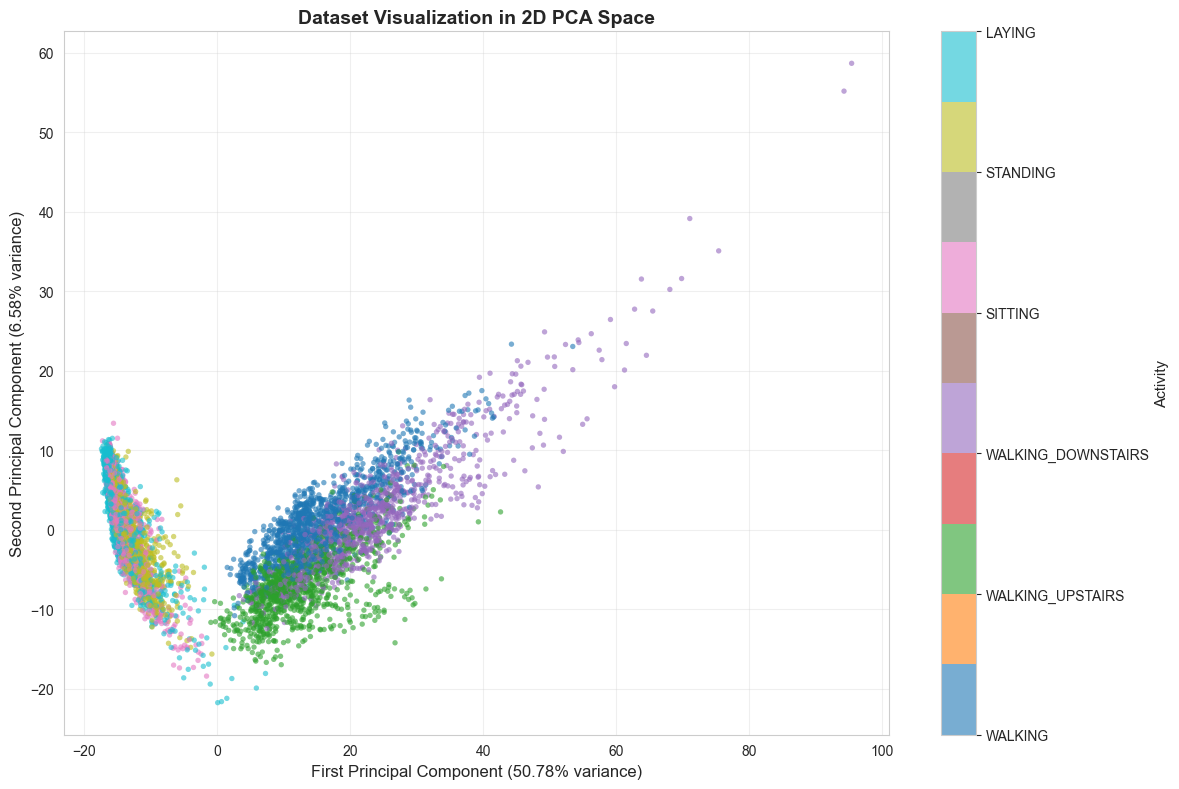

First two components explain 57.36% of variance


In [ ]:
#2D PCA Visualization (Step 2 - Part 3)
# ============================================================================
# Transform to 2D using first two principal components
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                     c=y_train, cmap='tab10', alpha=0.6, s=15, edgecolors='none')

plt.xlabel(f'First Principal Component ({pca_2d.explained_variance_ratio_[0]:.2%} variance)', 
           fontsize=12)
plt.ylabel(f'Second Principal Component ({pca_2d.explained_variance_ratio_[1]:.2%} variance)', 
           fontsize=12)
plt.title('Dataset Visualization in 2D PCA Space', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(1, 7))
cbar.set_label('Activity', fontsize=11)
cbar.set_ticklabels([activity_labels[i] for i in range(1, 7)])

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_2d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"First two components explain {(pca_2d.explained_variance_ratio_[0] + pca_2d.explained_variance_ratio_[1]):.2%} of variance")


Performing K-Means clustering with silhouette analysis...
K=2: Silhouette Score = 0.3965
K=3: Silhouette Score = 0.3274
K=4: Silhouette Score = 0.1652
K=5: Silhouette Score = 0.1306
K=6: Silhouette Score = 0.1086
K=7: Silhouette Score = 0.1114
K=8: Silhouette Score = 0.0739
K=9: Silhouette Score = 0.0777
K=10: Silhouette Score = 0.0814

*** Optimal number of clusters: 2 (score: 0.3965) ***


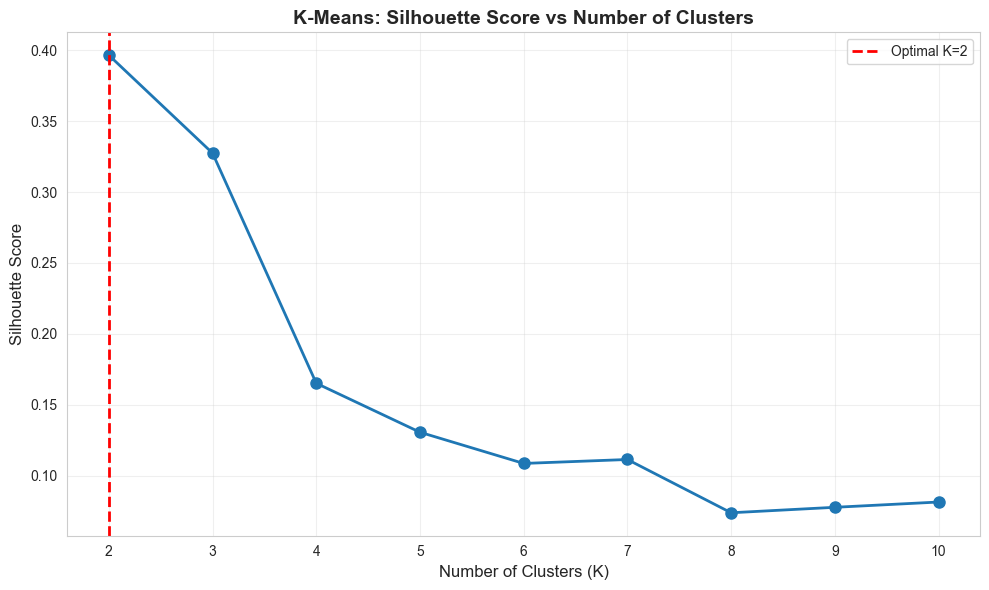


K-Means clustering complete with 2 clusters


In [ ]:
# K-Means Clustering with Silhouette Analysis (Step 3 - Part 1)
# ============================================================================
print("Performing K-Means clustering with silhouette analysis...")

# Test different numbers of clusters
K_range = range(2, 11)
silhouette_scores = []

for n_clusters in K_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    score = silhouette_score(X_train_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"K={n_clusters}: Silhouette Score = {score:.4f}")

# Find optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print(f"\n*** Optimal number of clusters: {optimal_k} (score: {best_score:.4f}) ***")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('K-Means: Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
plt.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K={optimal_k}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('kmeans_silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Train final K-Means model with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_train_scaled)

print(f"\nK-Means clustering complete with {optimal_k} clusters")


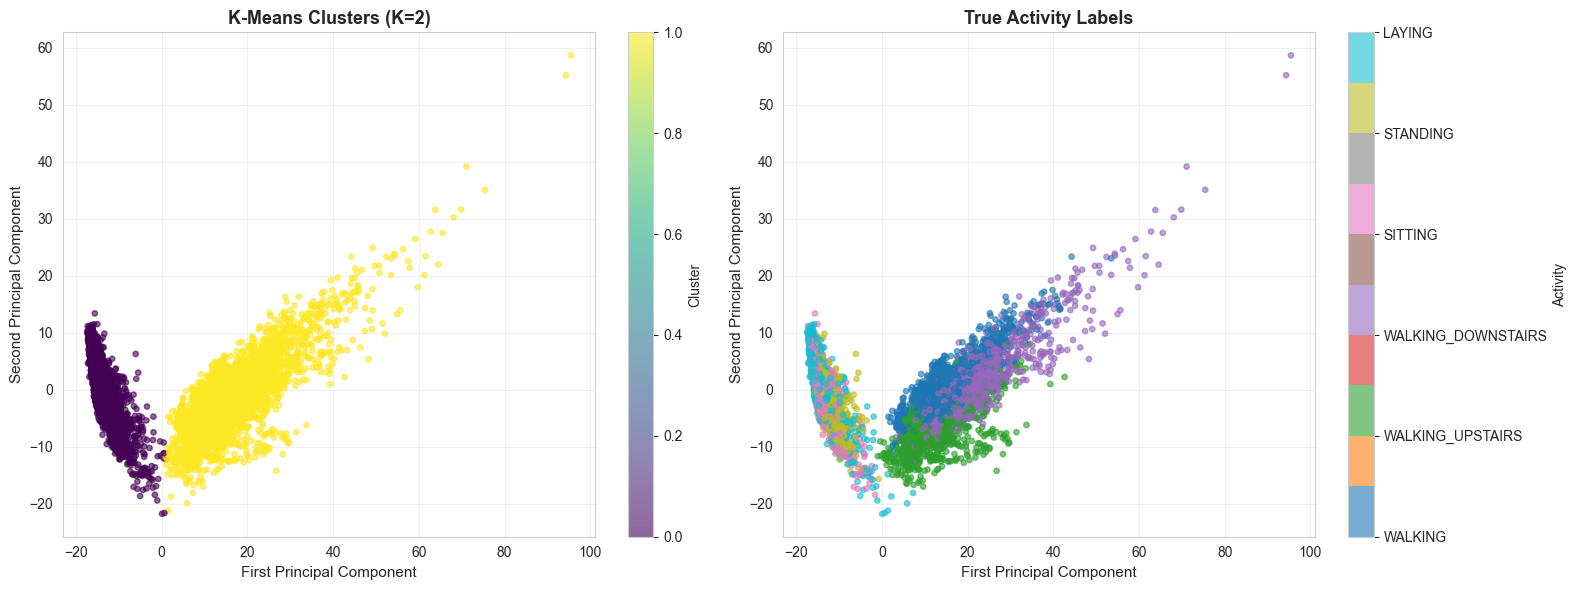


K-Means Cluster Distribution:
Cluster 0: 4063 samples (55.3%)
Cluster 1: 3289 samples (44.7%)


In [ ]:
# K-Means Visualization (Step 3 - Part 2)
# ============================================================================
# Visualize K-Means clusters using first two PCs
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Cluster labels
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=kmeans_labels, cmap='viridis', alpha=0.6, s=15)
axes[0].set_xlabel('First Principal Component', fontsize=11)
axes[0].set_ylabel('Second Principal Component', fontsize=11)
axes[0].set_title(f'K-Means Clusters (K={optimal_k})', fontsize=13, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right: True activity labels
scatter2 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=y_train, cmap='tab10', alpha=0.6, s=15)
axes[1].set_xlabel('First Principal Component', fontsize=11)
axes[1].set_ylabel('Second Principal Component', fontsize=11)
axes[1].set_title('True Activity Labels', fontsize=13, fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=axes[1], ticks=range(1, 7))
cbar2.set_label('Activity', fontsize=10)
cbar2.set_ticklabels([activity_labels[i] for i in range(1, 7)])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kmeans_clusters_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze cluster distribution
unique, counts = np.unique(kmeans_labels, return_counts=True)
print("\nK-Means Cluster Distribution:")
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} samples ({count/len(kmeans_labels)*100:.1f}%)")

In [ ]:
# ============================================================================
# DBSCAN Clustering with Better Parameters
# ============================================================================
print("Performing DBSCAN clustering...")

# Try multiple parameter combinations
eps_values = [10, 15, 20]
min_samples_value = 10

print("\nTesting different eps values:")
results_dbscan = []

for eps in eps_values:
    dbscan_test = DBSCAN(eps=eps, min_samples=min_samples_value)
    labels_test = dbscan_test.fit_predict(X_train_scaled)
    n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise = list(labels_test).count(-1)
    
    print(f"\neps={eps}, min_samples={min_samples_value}:")
    print(f"  Clusters: {n_clusters}")
    print(f"  Noise points: {n_noise} ({n_noise/len(labels_test)*100:.1f}%)")
    
    results_dbscan.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': n_noise/len(labels_test)*100
    })

# Select best eps value (one with reasonable clusters and not too much noise)
# Usually we want: 1-10 clusters and <50% noise
best_eps = 15  # You can adjust this based on the output above

print(f"\n{'='*60}")
print(f"Using eps={best_eps} for final DBSCAN model")
print(f"{'='*60}")

# Final DBSCAN with chosen parameters
dbscan = DBSCAN(eps=best_eps, min_samples=min_samples_value)
dbscan_labels = dbscan.fit_predict(X_train_scaled)

# Calculate statistics
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nFinal DBSCAN Results (eps={best_eps}, min_samples={min_samples_value}):")
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")

# Calculate silhouette score (excluding noise points)
if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    if np.sum(mask) > 0 and len(set(dbscan_labels[mask])) > 1:
        score = silhouette_score(X_train_scaled[mask], dbscan_labels[mask])
        print(f"Silhouette Score (excluding noise): {score:.4f}")

# Cluster distribution
print("\nDBSCAN Cluster Distribution:")
unique, counts = np.unique(dbscan_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    if cluster == -1:
        print(f"Noise: {count} samples ({count/len(dbscan_labels)*100:.1f}%)")
    else:
        print(f"Cluster {cluster}: {count} samples ({count/len(dbscan_labels)*100:.1f}%)")

# Analyze which activities ended up as noise
if n_noise > 0:
    print("\nActivity composition of noise points:")
    noise_mask = dbscan_labels == -1
    noise_activities = y_train[noise_mask]
    for activity_id in range(1, 7):
        count = np.sum(noise_activities == activity_id)
        pct = count / n_noise * 100 if n_noise > 0 else 0
        print(f"  {activity_labels[activity_id]:20s}: {count:4d} ({pct:.1f}% of noise)")

Performing DBSCAN clustering...

Testing different eps values:

eps=10, min_samples=10:
  Clusters: 8
  Noise points: 5727 (77.9%)

eps=15, min_samples=10:
  Clusters: 4
  Noise points: 1623 (22.1%)

eps=20, min_samples=10:
  Clusters: 1
  Noise points: 337 (4.6%)

Using eps=15 for final DBSCAN model

Final DBSCAN Results (eps=15, min_samples=10):
Number of clusters: 4
Number of noise points: 1623 (22.1%)
Silhouette Score (excluding noise): 0.2312

DBSCAN Cluster Distribution:
Noise: 1623 samples (22.1%)
Cluster 0: 5678 samples (77.2%)
Cluster 1: 19 samples (0.3%)
Cluster 2: 21 samples (0.3%)
Cluster 3: 11 samples (0.1%)

Activity composition of noise points:
  WALKING             :  311 (19.2% of noise)
  WALKING_UPSTAIRS    :  266 (16.4% of noise)
  WALKING_DOWNSTAIRS  :  789 (48.6% of noise)
  SITTING             :   88 (5.4% of noise)
  STANDING            :   39 (2.4% of noise)
  LAYING              :  130 (8.0% of noise)


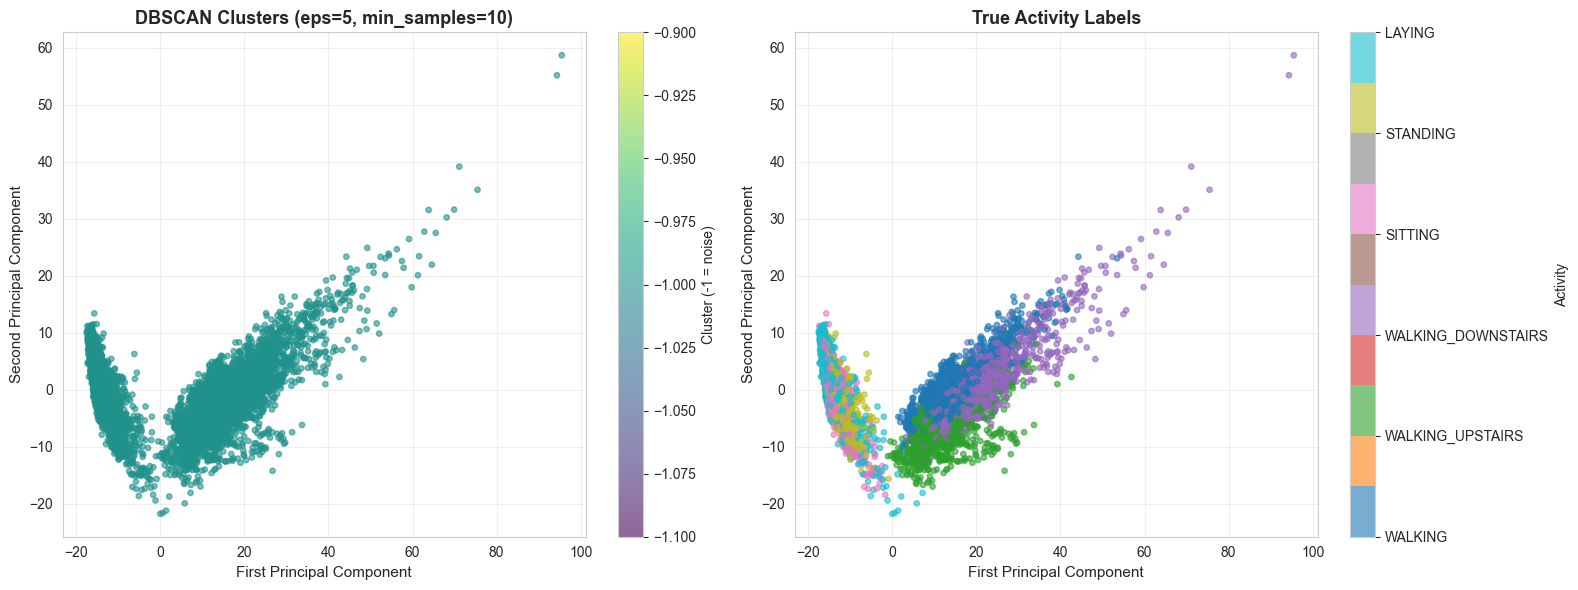

In [ ]:
# DBSCAN Visualization (Step 3 - Part 4)
# ============================================================================
# Visualize DBSCAN clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: DBSCAN cluster labels
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=dbscan_labels, cmap='viridis', alpha=0.6, s=15)
axes[0].set_xlabel('First Principal Component', fontsize=11)
axes[0].set_ylabel('Second Principal Component', fontsize=11)
axes[0].set_title(f'DBSCAN Clusters (eps={eps}, min_samples={min_samples})', 
                  fontsize=13, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster (-1 = noise)', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right: True activity labels
scatter2 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=y_train, cmap='tab10', alpha=0.6, s=15)
axes[1].set_xlabel('First Principal Component', fontsize=11)
axes[1].set_ylabel('Second Principal Component', fontsize=11)
axes[1].set_title('True Activity Labels', fontsize=13, fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=axes[1], ticks=range(1, 7))
cbar2.set_label('Activity', fontsize=10)
cbar2.set_ticklabels([activity_labels[i] for i in range(1, 7)])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dbscan_clusters_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Feature Selection - PCA (Step 4 - Part 1)
# ============================================================================
print(f"Performing PCA feature selection with k={k} components...")

# Apply PCA with k components
pca_k = PCA(n_components=k)
X_train_pca = pca_k.fit_transform(X_train_scaled)
X_test_pca = pca_k.transform(X_test_scaled)

print(f"\nPCA Feature Selection Results:")
print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Reduced features: {X_train_pca.shape[1]}")
print(f"Variance explained: {np.sum(pca_k.explained_variance_ratio_):.4f} ({np.sum(pca_k.explained_variance_ratio_)*100:.2f}%)")
print(f"Shape of PCA-transformed training data: {X_train_pca.shape}")
print(f"Shape of PCA-transformed test data: {X_test_pca.shape}")

Performing PCA feature selection with k=102 components...

PCA Feature Selection Results:
Original features: 561
Reduced features: 102
Variance explained: 0.9508 (95.08%)
Shape of PCA-transformed training data: (7352, 102)
Shape of PCA-transformed test data: (2947, 102)



Performing Random Forest feature selection with k=102 features...
Training Random Forest (this may take a minute)...

Random Forest Feature Selection Results:
Original features: 561
Selected features: 102

Top 10 most important features:
  Feature 40: importance = 0.037912
  Feature 49: importance = 0.030716
  Feature 558: importance = 0.028821
  Feature 41: importance = 0.027978
  Feature 56: importance = 0.024747
  Feature 559: importance = 0.024599
  Feature 52: importance = 0.023671
  Feature 53: importance = 0.021571
  Feature 50: importance = 0.020367
  Feature 57: importance = 0.015491

Shape of RF-selected training data: (7352, 102)
Shape of RF-selected test data: (2947, 102)


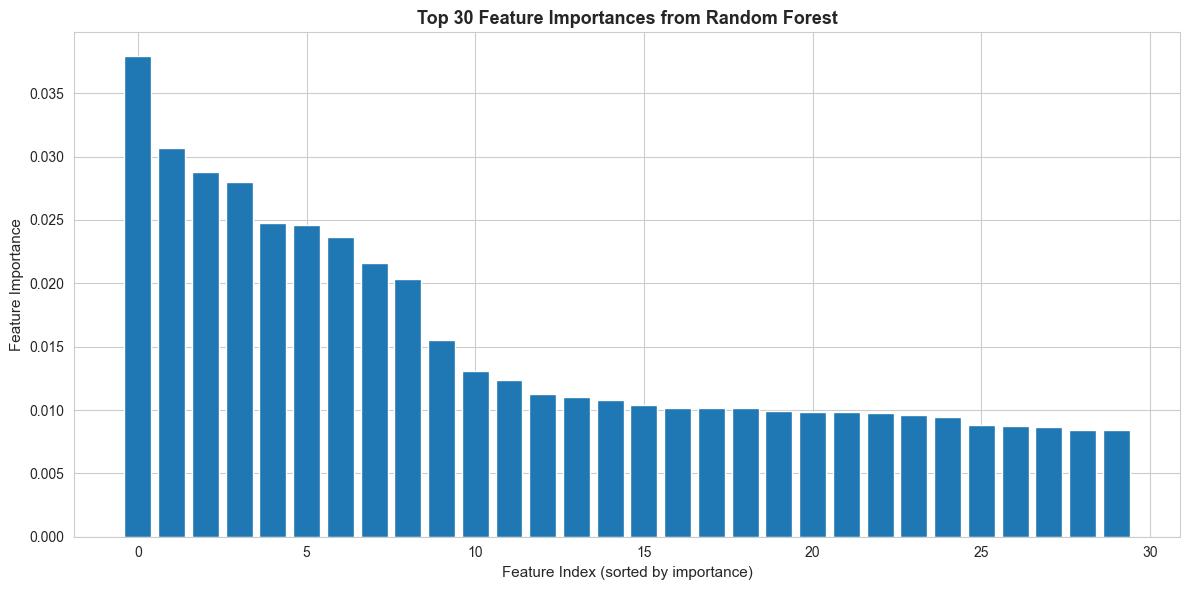

In [ ]:
# Feature Selection - Random Forest (Step 4 - Part 2)
# ============================================================================
print(f"\nPerforming Random Forest feature selection with k={k} features...")

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Training Random Forest (this may take a minute)...")
rf.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top k features
top_k_indices = indices[:k]

print(f"\nRandom Forest Feature Selection Results:")
print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Selected features: {len(top_k_indices)}")
print(f"\nTop 10 most important features:")
for i in range(min(10, k)):
    print(f"  Feature {indices[i]}: importance = {importances[indices[i]]:.6f}")

# Create reduced datasets
X_train_rf = X_train_scaled[:, top_k_indices]
X_test_rf = X_test_scaled[:, top_k_indices]

print(f"\nShape of RF-selected training data: {X_train_rf.shape}")
print(f"Shape of RF-selected test data: {X_test_rf.shape}")

# Visualize feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(min(30, len(importances))), importances[indices[:min(30, len(importances))]])
plt.xlabel('Feature Index (sorted by importance)', fontsize=11)
plt.ylabel('Feature Importance', fontsize=11)
plt.title('Top 30 Feature Importances from Random Forest', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('rf_feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Classification - Full Features (Step 5 - Part 1)
# ============================================================================
print("\n" + "="*70)
print("CLASSIFICATION: Model 1 - Full Feature Set")
print("="*70)

# Train model with all features
model_full = LogisticRegression(max_iter=1000, random_state=42)
print("Training Logistic Regression with all features...")
model_full.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_full = model_full.predict(X_test_scaled)

# Calculate metrics
acc_full = accuracy_score(y_test, y_pred_full)
prec_full = precision_score(y_test, y_pred_full, average='weighted')
rec_full = recall_score(y_test, y_pred_full, average='weighted')
f1_full = f1_score(y_test, y_pred_full, average='weighted')

print(f"\nResults - Full Features ({X_train_scaled.shape[1]} features):")
print(f"  Accuracy:  {acc_full:.4f}")
print(f"  Precision: {prec_full:.4f}")
print(f"  Recall:    {rec_full:.4f}")
print(f"  F1-Score:  {f1_full:.4f}")



CLASSIFICATION: Model 1 - Full Feature Set
Training Logistic Regression with all features...

Results - Full Features (561 features):
  Accuracy:  0.9549
  Precision: 0.9566
  Recall:    0.9549
  F1-Score:  0.9548


In [ ]:
# Classification - PCA Features (Step 5 - Part 2)
# ============================================================================
print("\n" + "="*70)
print(f"CLASSIFICATION: Model 2 - PCA Features (k={k})")
print("="*70)

# Train model with PCA features
model_pca = LogisticRegression(max_iter=1000, random_state=42)
print(f"Training Logistic Regression with {k} PCA components...")
model_pca.fit(X_train_pca, y_train)

# Predict on test set
y_pred_pca = model_pca.predict(X_test_pca)

# Calculate metrics
acc_pca = accuracy_score(y_test, y_pred_pca)
prec_pca = precision_score(y_test, y_pred_pca, average='weighted')
rec_pca = recall_score(y_test, y_pred_pca, average='weighted')
f1_pca = f1_score(y_test, y_pred_pca, average='weighted')

print(f"\nResults - PCA Features ({k} components):")
print(f"  Accuracy:  {acc_pca:.4f}")
print(f"  Precision: {prec_pca:.4f}")
print(f"  Recall:    {rec_pca:.4f}")
print(f"  F1-Score:  {f1_pca:.4f}")


CLASSIFICATION: Model 2 - PCA Features (k=102)
Training Logistic Regression with 102 PCA components...

Results - PCA Features (102 components):
  Accuracy:  0.9308
  Precision: 0.9313
  Recall:    0.9308
  F1-Score:  0.9306


In [ ]:
# Classification - RF Selected Features (Step 5 - Part 3)
# ============================================================================
print("\n" + "="*70)
print(f"CLASSIFICATION: Model 3 - Random Forest Selected Features (k={k})")
print("="*70)

# Train model with RF selected features
model_rf = LogisticRegression(max_iter=1000, random_state=42)
print(f"Training Logistic Regression with {k} RF-selected features...")
model_rf.fit(X_train_rf, y_train)

# Predict on test set
y_pred_rf = model_rf.predict(X_test_rf)

# Calculate metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average='weighted')
rec_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\nResults - RF Selected Features ({k} features):")
print(f"  Accuracy:  {acc_rf:.4f}")
print(f"  Precision: {prec_rf:.4f}")
print(f"  Recall:    {rec_rf:.4f}")
print(f"  F1-Score:  {f1_rf:.4f}")



CLASSIFICATION: Model 3 - Random Forest Selected Features (k=102)
Training Logistic Regression with 102 RF-selected features...

Results - RF Selected Features (102 features):
  Accuracy:  0.9301
  Precision: 0.9321
  Recall:    0.9301
  F1-Score:  0.9300



FINAL COMPARISON: All Models

                     Accuracy  Precision    Recall  F1-Score
Full Features (561)  0.954869   0.956608  0.954869  0.954792
PCA (102)            0.930777   0.931326  0.930777  0.930600
RF Selected (102)    0.930098   0.932086  0.930098  0.929984

Results saved to 'model_comparison.csv'


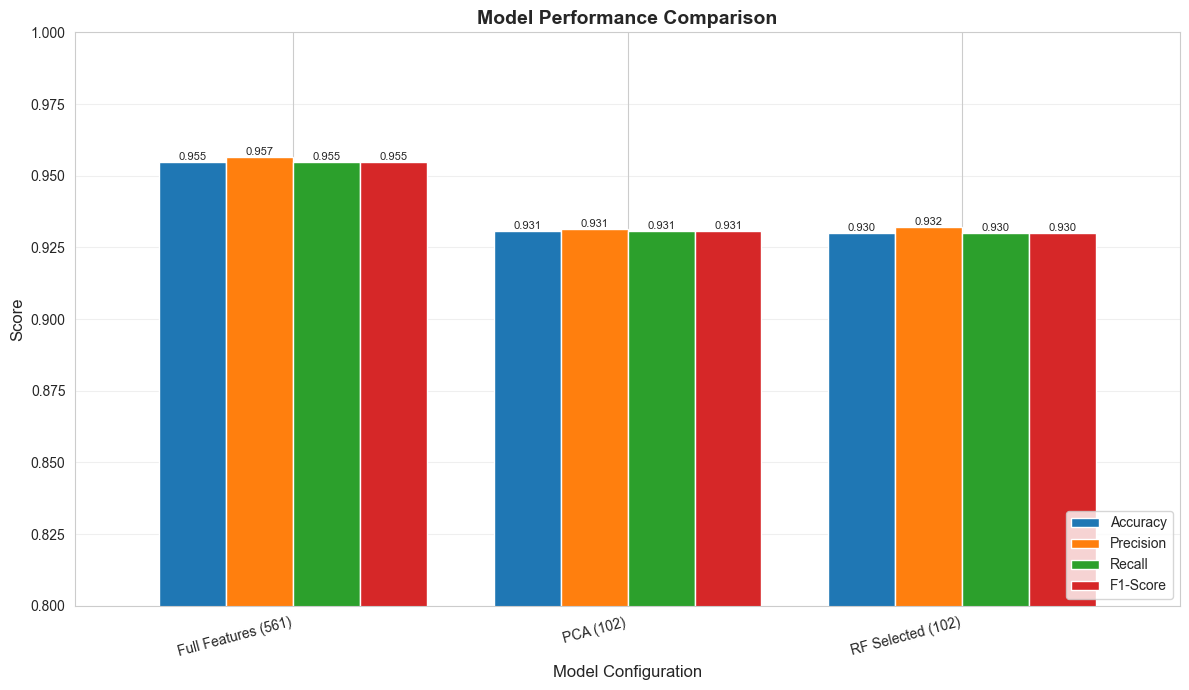


ANALYSIS COMPLETE!

Generated files:
  - activity_distribution.png
  - pca_explained_variance.png
  - pca_2d_visualization.png
  - kmeans_silhouette_analysis.png
  - kmeans_clusters_visualization.png
  - dbscan_clusters_visualization.png
  - rf_feature_importances.png
  - model_comparison.png
  - model_comparison.csv


In [ ]:
# Model Comparison and Visualization (Step 5 - Part 4)
# ============================================================================
print("\n" + "="*70)
print("FINAL COMPARISON: All Models")
print("="*70)

# Create comparison dataframe
results = {
    'Full Features (561)': {
        'Accuracy': acc_full,
        'Precision': prec_full,
        'Recall': rec_full,
        'F1-Score': f1_full
    },
    f'PCA ({k})': {
        'Accuracy': acc_pca,
        'Precision': prec_pca,
        'Recall': rec_pca,
        'F1-Score': f1_pca
    },
    f'RF Selected ({k})': {
        'Accuracy': acc_rf,
        'Precision': prec_rf,
        'Recall': rec_rf,
        'F1-Score': f1_rf
    }
}

results_df = pd.DataFrame(results).T
print("\n" + results_df.to_string())

# Save to CSV
results_df.to_csv('model_comparison.csv')
print("\nResults saved to 'model_comparison.csv'")

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 7))
results_df.plot(kind='bar', ax=ax, width=0.8)
plt.xlabel('Model Configuration', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.legend(loc='lower right', fontsize=10)
plt.ylim(0.8, 1.0)  # Adjust based on your results
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=8)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print(f"\nGenerated files:")
print("  - activity_distribution.png")
print("  - pca_explained_variance.png")
print("  - pca_2d_visualization.png")
print("  - kmeans_silhouette_analysis.png")
print("  - kmeans_clusters_visualization.png")
print("  - dbscan_clusters_visualization.png")
print("  - rf_feature_importances.png")
print("  - model_comparison.png")
print("  - model_comparison.csv")